In [1]:
import matplotlib.pyplot as plt
import numpy as np
import IPython
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_io as tfio
import functools
from pedalboard import load_plugin
from ReverberatorEstimator import layers, loss, models
import warnings
warnings.filterwarnings('ignore')
import time
import os
import librosa.display

2021-11-29 15:57:04.105051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 15:57:04.105088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sample_rate = 48000
num_params = 112

In [3]:
target_audio = tfio.audio.AudioIOTensor("snap_wet.wav")
target_audio = target_audio.to_tensor()
target_audio = tf.slice(target_audio, begin=[0,0], size=[-1,1])
target_audio = tf.cast(target_audio, tf.float32) / 32768.0
target_audio = tf.squeeze(target_audio)
target_audio = tf.reshape(target_audio,(1, 96000))
input_audio = tfio.audio.AudioIOTensor("snap_dry.wav")
input_audio = input_audio.to_tensor()
input_audio = tf.slice(input_audio, begin=[0,0], size=[-1,1])
input_audio = tf.cast(input_audio, tf.float32) / 32768.0
input_audio = tf.squeeze(input_audio)
input_audio = tf.reshape(input_audio,(1, 96000))

2021-11-29 15:57:05.911780: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2021-11-29 15:57:06.105247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 15:57:06.105348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-29 15:57:06.105423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-29 15:57:06.105497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dl

In [33]:
logmelgram = layers.LogMelgramLayer(1024, 256, 128, sample_rate, 0.0, sample_rate//2, 1e-6)
audio_time = tfkl.Input(shape=(96000,), name="audio_time")
x = logmelgram(audio_time)
x = tfkl.BatchNormalization(name="input_norm")(x)
encoder_model = tfk.applications.MobileNetV2(input_shape=(x.shape[1], x.shape[2], x.shape[3]), alpha=1.0,
                                            include_top=True, weights=None, input_tensor=None, pooling=None,
                                            classes=np.sum(num_params).item(), classifier_activation="sigmoid")

hidden = encoder_model(x)

parameter_model = tfk.models.Model(audio_time, hidden, name="parameter_model")

parameters = parameter_model(audio_time)

# x = tfkl.Dense(1000, activation="sigmoid")(audio_time)
# hidden_params = tfkl.Dense(112,activation="sigmoid")(x)

vstlayer = layers.VSTProcessor("../Reverberator.vst3", sample_rate)
output = vstlayer([audio_time, parameters])

model = tfk.models.Model(audio_time, output, name="full_model")

spectral_loss = loss.multiScaleSpectralLoss(
#                                             loss_type='L1',
#                                                    mag_weight=1.,
#                                                    #logmag_weight=1.,
#                                             time_loss=True,
#                                             time_loss_type='L1',
#                                             time_loss_weight=10.0,
                                             fft_sizes=(2048, 1024, 512, 256, 128, 64),
# #                                             overlap=0.75,
# #                                              time_shifting=True,
                                             batch_size=1,
                                             sr=sample_rate)

optimizer = tfk.optimizers.Adam(learning_rate=0.01)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint_manager = tf.train.CheckpointManager(checkpoint=checkpoint, 
                                               directory=checkpoint_dir,
                                               max_to_keep=5)

In [34]:
parameter_model.summary()
model.summary()

Model: "parameter_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_time (InputLayer)      [(None, 96000)]           0         
_________________________________________________________________
log_melgram_layer_1 (LogMelg (None, 372, 128, 1)       0         
_________________________________________________________________
input_norm (BatchNormalizati (None, 372, 128, 1)       4         
_________________________________________________________________
mobilenetv2_1.00_372 (Functi (None, 112)               2400880   
Total params: 2,400,884
Trainable params: 2,366,770
Non-trainable params: 34,114
_________________________________________________________________
Model: "full_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio_time (Inpu

In [35]:
# Restore from latest checkpoint
checkpoint_manager.restore_or_initialize()


'./training_checkpoints/ckpt-67'

In [7]:
audio_pre = (model.call(input_audio)).numpy()[0]
old_params = parameter_model(input_audio).numpy()[0]

No protocol specified
No protocol specified


In [36]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [37]:
epochs = 30
losses = np.zeros(epochs)
start_time = time.time()
for epoch in range(epochs):
    
    print("\nStart of epoch %d" % (epoch,))
    
    with tf.GradientTape() as tape:
        output = model(input_audio, training=True)
        loss_value = spectral_loss(target_audio, output)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
        "Training loss at epoch %d: %s"
        % (epoch, "{:e}".format(loss_value))
    )
    losses[epoch] = loss_value
    if epoch % 100 == 0:
        print("Saving checkpoint")
        checkpoint_manager.save()
print("Training took %d seconds" % (time.time() - start_time))


Start of epoch 0
Training loss at epoch 0: 1.683811e-01
Saving checkpoint

Start of epoch 1
Training loss at epoch 1: 1.683811e-01

Start of epoch 2
Training loss at epoch 2: 1.683811e-01

Start of epoch 3
Training loss at epoch 3: 1.683811e-01

Start of epoch 4
Training loss at epoch 4: 1.683811e-01

Start of epoch 5
Training loss at epoch 5: 1.683811e-01

Start of epoch 6
Training loss at epoch 6: 1.683811e-01

Start of epoch 7
Training loss at epoch 7: 1.683811e-01

Start of epoch 8
Training loss at epoch 8: 1.683811e-01

Start of epoch 9
Training loss at epoch 9: 1.683811e-01

Start of epoch 10
Training loss at epoch 10: 1.683811e-01

Start of epoch 11
Training loss at epoch 11: 1.683811e-01

Start of epoch 12
Training loss at epoch 12: 1.683811e-01

Start of epoch 13
Training loss at epoch 13: 1.683811e-01

Start of epoch 14
Training loss at epoch 14: 1.683811e-01

Start of epoch 15
Training loss at epoch 15: 1.683811e-01

Start of epoch 16
Training loss at epoch 16: 1.683811e-01

Text(0.5, 1.0, 'Loss')

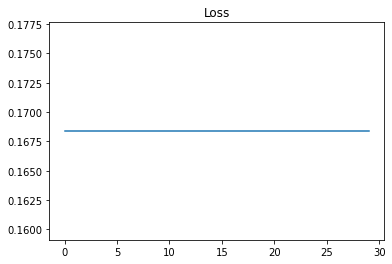

In [38]:
plt.plot(losses)
plt.title("Loss")

In [39]:
output_audio = model(input_audio)

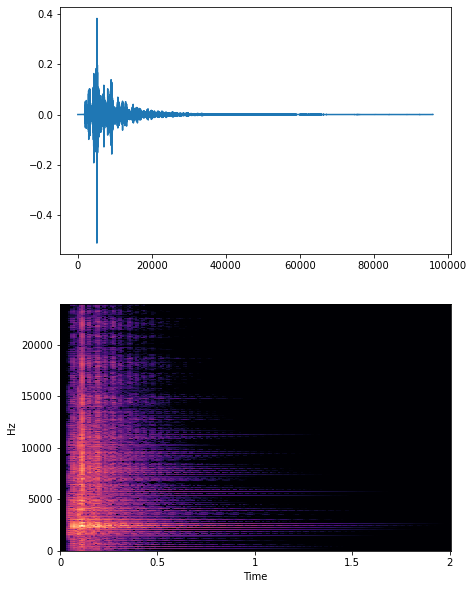

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
ax[0].plot(audio_pre)
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_pre)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1])

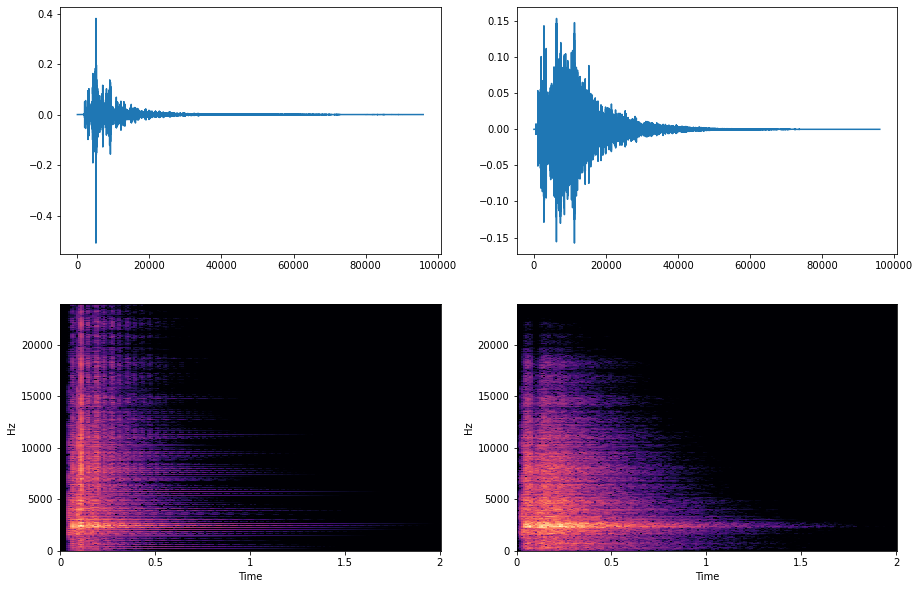

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0,0].plot(output_audio.numpy()[0])
D = librosa.amplitude_to_db(np.abs(librosa.stft(output_audio.numpy()[0])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1,0])
ax[0,1].plot(target_audio.numpy()[0])
D = librosa.amplitude_to_db(np.abs(librosa.stft(target_audio.numpy()[0])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1,1])

In [42]:
IPython.display.Audio(output_audio, rate=sample_rate, autoplay=True)

In [43]:
IPython.display.Audio(audio_pre, rate=sample_rate)

In [44]:
IPython.display.Audio(target_audio, rate=sample_rate)

In [45]:
# Dump values to .csv files
np.savetxt("output_audio.csv", output_audio, delimiter=",")
np.savetxt("target_audio.csv", (target_audio.numpy()[0]), delimiter=",")

In [46]:
parameters = parameter_model(input_audio)

In [47]:
params = parameters.numpy()[0]
filter_c = 1
for i in range(num_params):
    if i < 16:
        print("b_%i = %f" % (i, params[i]))
    elif i < 32:
        print("c_%i = %f" % (i-16, params[i]))
    else:
        j = (i-32) % 5
        
        if j is 0:
            print("\nFilter %i:" % filter_c)
            filter_c = filter_c + 1
            print("c_hp = %f" % params[i])
        elif j is 1:
            print("c_bp = %f" % params[i])
        elif j is 2:
            print("c_lp = %f" % params[i])
        elif j is 3:
            print("g = %f" % params[i])
        elif j is 4:
            print("R = %f" % params[i])

b_0 = 0.945933
b_1 = 0.006796
b_2 = 0.002730
b_3 = 0.037814
b_4 = 0.993725
b_5 = 0.881604
b_6 = 0.994913
b_7 = 0.005885
b_8 = 0.006200
b_9 = 0.999431
b_10 = 0.002222
b_11 = 0.970993
b_12 = 0.996717
b_13 = 0.003296
b_14 = 0.000982
b_15 = 0.994660
c_0 = 0.047240
c_1 = 0.084527
c_2 = 0.008272
c_3 = 0.994910
c_4 = 0.001838
c_5 = 0.992567
c_6 = 0.006704
c_7 = 0.005256
c_8 = 0.974541
c_9 = 0.000204
c_10 = 0.996194
c_11 = 0.999216
c_12 = 0.009112
c_13 = 0.818707
c_14 = 0.995716
c_15 = 0.000360

Filter 1:
c_hp = 0.112382
c_bp = 0.058640
c_lp = 0.999382
g = 0.992377
R = 0.984016

Filter 2:
c_hp = 0.989522
c_bp = 0.009675
c_lp = 0.001076
g = 0.997362
R = 0.001599

Filter 3:
c_hp = 0.999799
c_bp = 0.003436
c_lp = 0.026456
g = 0.024291
R = 0.026515

Filter 4:
c_hp = 0.996350
c_bp = 0.995412
c_lp = 0.999200
g = 0.750732
R = 0.993504

Filter 5:
c_hp = 0.974111
c_bp = 0.888716
c_lp = 0.003479
g = 0.081009
R = 0.003339

Filter 6:
c_hp = 0.999003
c_bp = 0.995730
c_lp = 0.016132
g = 0.993890
R = 0.98443

[-3.58879566e-04  1.36584044e-04  3.37660313e-05  4.95076180e-04
 -1.15692616e-04 -2.67148018e-04 -9.04798508e-05  1.28537416e-04
  8.33272934e-05 -1.26361847e-05  4.13060188e-05 -3.04341316e-04
 -4.79817390e-05  6.04093075e-05  1.80304050e-05 -9.99569893e-05
  3.88801098e-04  6.70015812e-04  1.64419413e-04 -1.03473663e-04
  4.20510769e-05 -1.55687332e-04  1.39623880e-04  7.75754452e-05
 -2.02596188e-04  6.58631325e-06 -6.23464584e-05 -2.05636024e-05
  1.29163265e-04 -5.65528870e-04 -5.74588776e-05  9.38773155e-06
  3.98486853e-04  5.82188368e-04 -1.44243240e-05 -1.45375729e-04
 -1.75833702e-04 -1.22904778e-04  1.48147345e-04  2.39908695e-05
 -5.41806221e-05  3.20076942e-05 -5.12599945e-06  6.63399696e-05
  3.50594521e-04  2.43782997e-04  3.89724970e-04 -4.76837158e-05
 -6.67572021e-05 -1.83582306e-05 -7.82370567e-04 -8.05854797e-05
 -2.59160995e-04 -8.39889050e-04  8.79764557e-05  7.42316246e-04
  5.63561916e-05 -1.78813934e-05 -7.12871552e-05  2.40921974e-04
 -1.05261803e-04 -2.90989

<StemContainer object of 3 artists>

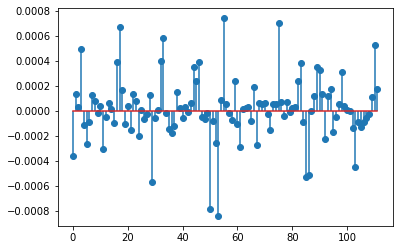

In [48]:
param_diff = old_params - params
print(param_diff)
plt.stem(param_diff)